# Models comparison using Caffe Sandbox

In [4]:
# ###########################################################
# ENVIRONMENT
# ###########################################################

# Location of Caffe and logging files and database
caffe_root = "$CAFFE_ROOT/"
caffe_path = "build/tools/caffe"
log_path = "logs/"
fig_path = "imgs/"
db_path = "../mnist/"

# Setting log environment variables before importing caffe
import os
os.environ["GLOG_log_dir"] = log_path # uncomment this line only if you use glog
#os.environ["GLOG_logtostderr"] = "1" # uncomment this line only if you use custom log

# Import necessary modules
%pylab inline
import sys
import subprocess
import logging
import time, datetime

# Caffe
import numpy as np
from numpy import *
import caffe
from caffe import layers as L, params as P

# Caffe Sandbox
from eval.learning_curve import LearningCurve
from eval.eval_utils import Phase
import eval.log_utils as lu

# ###########################################################
# DATA
# ###########################################################

# Data already converted to lmdb

# Relative location of train/test networks and solver
def get_locations(prefix_net):
    train_net_path = "prototxt/"+prefix_net+"_train.prototxt"
    test_net_path = "prototxt/"+prefix_net+"_test.prototxt"
    solver_config_path = "prototxt/"+prefix_net+"_solver.prototxt"
    return train_net_path, test_net_path, solver_config_path


# ###########################################################
# ARCHITECTURE
# ###########################################################

# Network 0
# INPUT -> FC -> FC -> SIGMOID
def net0(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.fc1 = L.InnerProduct(n.data, num_output=50, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.fc1)
    n.fc2 = L.InnerProduct(n.sig1, num_output=50, weight_filler=dict(type='xavier'))
    n.sig2 = L.Sigmoid(n.fc2)
    n.score = L.InnerProduct(n.sig2, num_output=10, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.score, n.label, include=[dict(phase=caffe.TEST)])
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()

# Network 1
# INPUT -> CONV -> RELU -> FC
def net1(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.fc1 = L.InnerProduct(n.relu1, num_output=500, weight_filler=dict(type='xavier'))
    n.score = L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.score, n.label, include=[dict(phase=caffe.TEST)])
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()

# Network 2
# INPUT -> [CONV -> POOL -> RELU]*2 -> FC -> RELU -> FC
def net2(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    n.conv2 = L.Convolution(n.relu1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    n.fc1 =   L.InnerProduct(n.relu2, num_output=500, weight_filler=dict(type='xavier'))
    n.score =   L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.score, n.label, include=[dict(phase=caffe.TEST)])
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()


# ###########################################################
# TRAIN/TEST/SOLVE
# ###########################################################

def make_train_test(net, train_net_path, test_net_path):
    
    with open(train_net_path, 'w') as f:
        f.write(str(net(db_path+"mnist_train_lmdb", 64)))
        
    with open(test_net_path, 'w') as f:
        f.write(str(net(db_path+"mnist_test_lmdb", 100)))

def make_solver(s, net_prefix, train_net_path, test_net_path, solver_config_path):
    
    # Randomization in training
    s.random_seed = 0xCAFFE

    # Locations of the train/test networks
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 10  # Test after every 500 training iterations.
    s.test_iter.append(100) # Test on 100 batches each time we test.

    s.max_iter = 10000 # Max training iterations

    # Type of solver
    s.type = "Nesterov" # "SGD", "Adam", and "Nesterov"

    # Initial learning rate and momentum
    s.base_lr = 0.01
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Learning rate changes
    s.lr_policy = 'inv'
    s.gamma = 0.0001
    s.power = 0.75

    # Display current training loss and accuracy every 10 iterations
    s.display = 10

    # Snapshots files (uncomment to get it)
    s.snapshot = 5000
    s.snapshot_prefix = "snapshots/"+net_prefix+"_snapshot"

    # Use GPU to train
    s.solver_mode = caffe_pb2.SolverParameter.GPU

    # Write the solver to a temporary file and return its filename
    with open(solver_config_path, "w") as f:
        f.write(str(s))
    
def train_test_net_command(solver_config_path):

    # Load solver
    solver = None
    solver = caffe.get_solver(solver_config_path)
    
    # Launch training command
    command = "{caffe} train -solver {solver}".format(caffe=caffe_root + caffe_path,
                                                      solver=solver_config_path)
    subprocess.call(command, shell=True)
    
def train_test_net_python(solver_config_path, niter):
    # Pythonic alternative to previous method
    
    # Work on GPU and load solver
    caffe.set_device(0)
    caffe.set_mode_gpu()
    solver = None
    solver = caffe.get_solver(solver_config_path)
    
    for it in range(niter):

        # SGD
        solver.step(1)

        # Display iteration
        if it % niter/10 == 0:
            print "Iteration", it, "testing..."
            

# ###########################################################
# LEARNING CURVE
# ###########################################################

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams.update({'font.size': 15})

def print_learning_curve(log_name, fig_name):

    e = LearningCurve(log_name)
    e.parse()

    for phase in [Phase.TRAIN, Phase.TEST]:
        num_iter = e.list('NumIters', phase)
        loss = e.list('loss', phase)
        plt.plot(num_iter, loss, label='on %s set' % (phase.lower(),))

        plt.xlabel('iteration')
        # format x-axis ticks
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
        plt.ylabel('loss')
        plt.title(net_prefix+' on train and test sets')
        plt.legend()

    plt.figure()
    num_iter = e.list('NumIters', phase)
    acc = e.list('accuracy', phase)
    plt.plot(num_iter, acc, label=e.name())

    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title(net_prefix+" on %s set" % (phase.lower(),))
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(fig_name)
    
def print_learning_curve_from_glog(net_prefix):
    e = LearningCurve(log_path + "caffe.INFO")
    e.parse()

    for phase in [Phase.TRAIN, Phase.TEST]:
        num_iter = e.list('NumIters', phase)
        loss = e.list('loss', phase)
        plt.plot(num_iter, loss, label='on %s set' % (phase.lower(),))

        plt.xlabel('iteration')
        # format x-axis ticks
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
        plt.ylabel('loss')
        plt.title(net_prefix+' on train and test sets')
        plt.legend()

    plt.figure()
    num_iter = e.list('NumIters', phase)
    acc = e.list('accuracy', phase)
    plt.plot(num_iter, acc, label=e.name())

    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title(net_prefix+" on %s set" % (phase.lower(),))
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


# ###########################################################
# WRITE TO LOG: log without glog which works poorly on python
# ###########################################################
    
import os
import sys

class OutputGrabber(object):
    """
    Class used to grab standard output or another stream.
    """
    escape_char = "\b"

    def __init__(self, stream):
        self.origstream = stream
        self.origstreamfd = self.origstream.fileno()
        self.capturedtext = ""
        # Create a pipe so the stream can be captured
        self.pipe_out, self.pipe_in = os.pipe()
        pass

    def start(self):
        """
        Start capturing the stream data.
        """
        self.capturedtext = ""
        # Save a copy of the stream
        self.streamfd = os.dup(self.origstreamfd)
        # Replace the Original stream with our write pipe
        os.dup2(self.pipe_in, self.origstreamfd)
        pass

    def stop(self, filename):
        """
        Stop capturing the stream data and save the text in `capturedtext`.
        """
        # Flush the stream to make sure all our data goes in before
        # the escape character.
        self.origstream.flush()
        # Print the escape character to make the readOutput method stop
        self.origstream.write(self.escape_char)
        self.readOutput()
        # Close the pipe
        os.close(self.pipe_out)
        # Restore the original stream
        os.dup2(self.streamfd, self.origstreamfd)
        # Write to file filename
        f = open(filename, "w")
        f.write(self.capturedtext)
        f.close()
        pass

    def readOutput(self):
        """
        Read the stream data (one byte at a time)
        and save the text in `capturedtext`.
        """
        while True:
            data = os.read(self.pipe_out, 1)  # Read One Byte Only
            if self.escape_char in data:
                break
            if not data:
                break
            self.capturedtext += data
        pass
    
    def write_output(self):
        """
        Write the stream data to a log file
        """
        # Time stamp
        ts = time.time()
        time_stamp = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')
        # Log name
        log_name = "mnist/logs/"+net+"_"+time_stamp+".log"

Populating the interactive namespace from numpy and matplotlib


Training: net0


/mnt/antares_raid/home/pierre/.virtualenvs/pierrenv/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


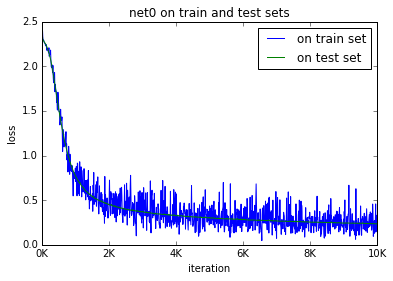

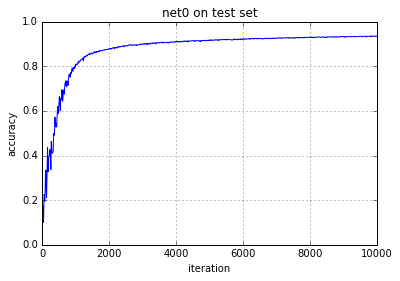

Training: net1


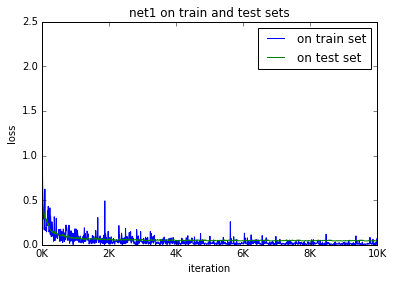

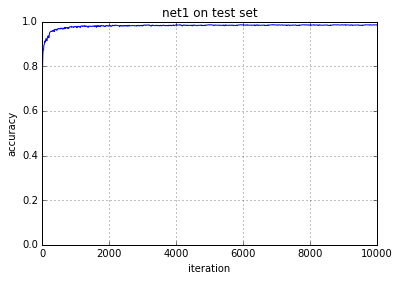

Training: net2


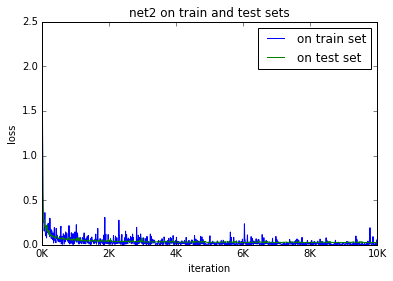

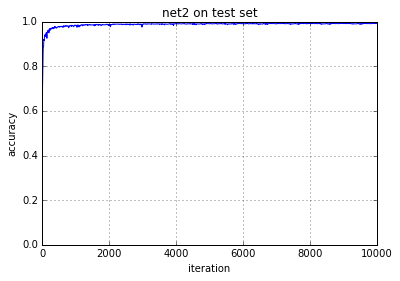

CPU times: user 2.21 s, sys: 787 ms, total: 2.99 s
Wall time: 1h 39min 5s


In [5]:
%%time

from caffe.proto import caffe_pb2

nets = [(net0, "net0"),
        (net1, "net1"),
        (net2, "net2")]

for (net, net_prefix) in nets:
    print "Training:", net_prefix
    s = caffe_pb2.SolverParameter()
    train_net_path, test_net_path, solver_config_path = get_locations(net_prefix)
    make_train_test(net, train_net_path, test_net_path)
    make_solver(s, net_prefix, train_net_path, test_net_path, solver_config_path)
    train_test_net_command(solver_config_path)
    print_learning_curve_from_glog(net_prefix)